# RSA between task features and model activations

In [10]:
from lstnn.compare_rdms import get_transformer_weights, create_ds_from_ann
from lstnn.dataset import get_dataset
import rsatoolbox
import numpy as np
import pandas as pd

n_layer = 4
data_dir = "/home/lukeh/projects/LSTNN/data/"
seeds = [2235, 6312, 6068, 9742, 8880, 2197, 669,
         6256, 3309, 2541, 8643, 7785, 195, 6914, 29]
rdm_method_ann = "euclidean"
pe_desc = "2dpe"
epoch = 4000

In [11]:
from scipy.spatial.distance import jaccard


def calc_jaccard(data):
    mat = np.zeros((108, 108))
    for i in range(108):
        for j in range(108):
            mat[i, j] = jaccard(data[i, :], data[j, :])
    return mat


def get_experimentor_rdms(LST_puzzle_ds, rdm_method):
    # visual input
    data = np.zeros((108, 80))
    for i in range(108):
        data[i, :] = LST_puzzle_ds[i][0].reshape(-1).numpy()

    # create description dict
    puzzles = ['LST' + str(i) for i in range(1, 108+1)]
    obs_des = {'puzzles': puzzles}

    # visual input
    mat = calc_jaccard(data)
    visual_rdm = rsatoolbox.rdm.RDMs(
        dissimilarities=mat.reshape(1, 108, 108),
        dissimilarity_measure='jaccard',
        rdm_descriptors={'name': "visual"},
        pattern_descriptors=obs_des,
    )

    # motor output, i.e., correct button presses
    data = np.zeros((108, 4))
    for i in range(108):
        data[i, :] = LST_puzzle_ds[i][1].reshape(-1).numpy()

    mat = calc_jaccard(data)
    motor_rdm = rsatoolbox.rdm.RDMs(
        dissimilarities=mat.reshape(1, 108, 108),
        dissimilarity_measure='jaccard',
        rdm_descriptors={'name': "motor"},
        pattern_descriptors=obs_des,
    )

    # Relational complexity
    data = np.ones((108, 108))
    data[0:36, 0:36] = 0
    data[36:72, 36:72] = 0
    data[72::, 72::] = 0
    data[0:36, 36:72] = 0.5
    data[36:72, 72::] = 0.5
    condition_rdm = rsatoolbox.rdm.RDMs(data.reshape(1, 108, 108),
                                        rdm_descriptors={'name': "complexity"},
                                        dissimilarity_measure='experimentor')

    output = []
    output.append(visual_rdm)
    output.append(condition_rdm)
    output.append(motor_rdm)
    return output


In [12]:
# read in ANN activations
# load test puzzles as a torch ds
LST_puzzle_ds = get_dataset(f"{data_dir}nn/puzzle_data_original.csv")

# Get task RDMS
task_rdms = get_experimentor_rdms(LST_puzzle_ds, rdm_method_ann)

# Combine into a list of rsatoolbox models
models = []
for rdm in task_rdms:
    label = rdm.rdm_descriptors['name'][0]
    m = rsatoolbox.model.ModelFixed(label, rdm)
    models.append(m)

# Get specified ANN models
weights = get_transformer_weights(LST_puzzle_ds, pe_desc, epoch)

# Calculate ANN RDMS
ds_list = []
for ann_label in ["pe", "attn_out", "mlp"]:
    for layer in range(n_layer):
        for seed in range(len(seeds)):
            data = weights[ann_label][seed, layer]
            des = {'model': ann_label, "layer": layer, "seed":seed}

            # generate information for puzzles, conditions and seeds
            puzzles = np.arange(1, 109)

            obs_des = {'puzzles': puzzles}

            ds = rsatoolbox.data.Dataset(measurements=data,
                                            descriptors=des,
                                            obs_descriptors=obs_des
                                            )
            ds_list.append(ds)

    # # also the avg.
    # for seed in range(len(seeds)):
    #     data = np.mean(weights[ann_label][seed], axis=0)
    #     des = {'model': ann_label, "layer": "avg", "seed": seed}

    #     # generate information for puzzles, conditions and seeds
    #     puzzles = np.arange(1, 109)

    #     obs_des = {'puzzles': puzzles}

    #     ds = rsatoolbox.data.Dataset(measurements=data,
    #                                     descriptors=des,
    #                                     obs_descriptors=obs_des
    #                                     )
    #     ds_list.append(ds)

rdms = rsatoolbox.rdm.calc_rdm(ds_list, method=rdm_method_ann, descriptor='puzzles')


task_results = []
for task_model in models:
    for ann_model in ["pe", "attn_out", "mlp"]:
        for layer in range(4):
            rdm_input = rdms.subset('model', ann_model).subset('layer', layer)
            results = rsatoolbox.inference.eval_fixed(task_model, rdm_input, method='corr')

            df = pd.DataFrame()
            df["values"] = np.squeeze(results.evaluations)
            df["ann_model"] = ann_model
            df["layer"] = layer
            df["task_model"] = task_model.name
            df["seed"] = range(15)
            task_results.append(df)


/home/lukeh/projects/LSTNN/lstnn/compare_rdms.py:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(
/home/lukeh/miniconda3/envs/lstann/lib/

### Repeat for the averages across layers

In [13]:
# Calculate ANN RDMS
avg_ds_list = []
for ann_label in ["pe", "attn_out", "mlp"]:
    # also the avg.
    for seed in range(len(seeds)):
        data = np.mean(weights[ann_label][seed], axis=0)
        des = {'model': ann_label, "seed": seed}

        # generate information for puzzles, conditions and seeds
        puzzles = np.arange(1, 109)

        obs_des = {'puzzles': puzzles}

        ds = rsatoolbox.data.Dataset(measurements=data,
                                        descriptors=des,
                                        obs_descriptors=obs_des
                                        )
        avg_ds_list.append(ds)

avg_rdms = rsatoolbox.rdm.calc_rdm(avg_ds_list, method=rdm_method_ann, descriptor='puzzles')

for task_model in models:
    for ann_model in ["pe", "attn_out", "mlp"]:

        rdm_input = avg_rdms.subset('model', ann_model)
        results = rsatoolbox.inference.eval_fixed(task_model, rdm_input, method='corr')

        df = pd.DataFrame()
        df["values"] = np.squeeze(results.evaluations)
        
        df["ann_model"] = ann_model
        df["layer"] = "average"
        df["task_model"] = task_model.name
        df["seed"] = range(15)
        task_results.append(df)
task_results = pd.concat(task_results)

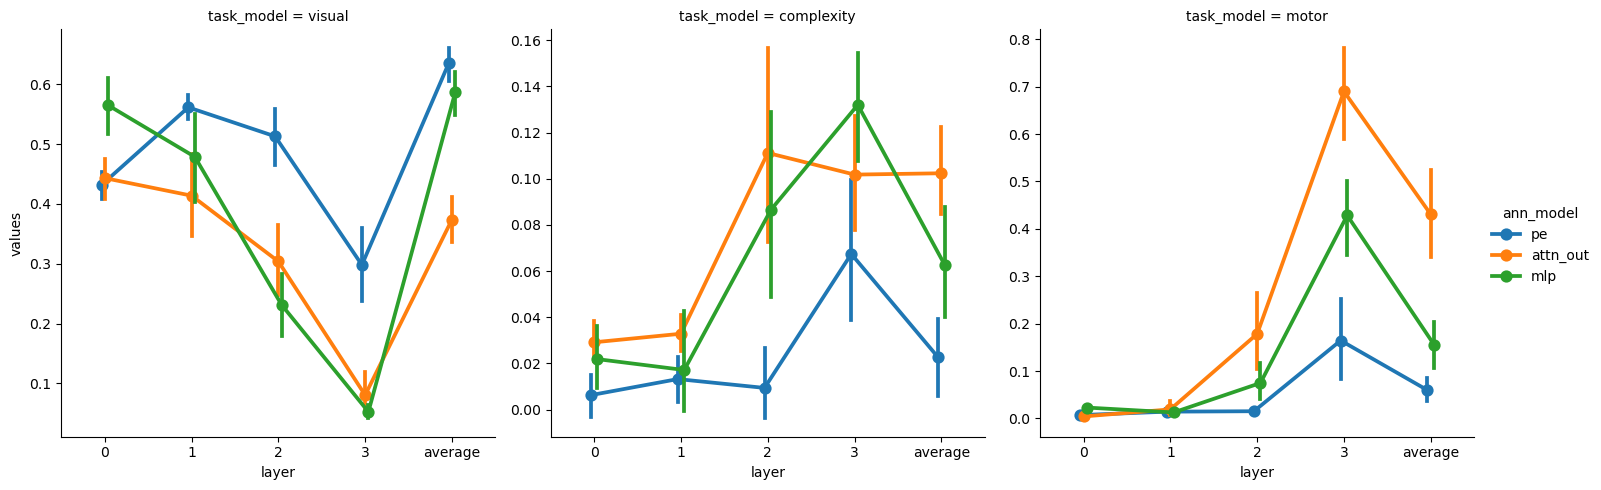

In [14]:
import seaborn as sns
sns.catplot(data=task_results, y="values", x="layer", col="task_model", hue="ann_model", kind="point", col_order=["visual", "complexity", "motor"], sharey=False, dodge=True)

# Statistics

In [15]:
import pingouin as pg
results = []
for m in ["visual", "complexity", "motor"]:
    print(m)
    data = task_results.loc[(task_results.task_model==m) 
                            & (task_results.layer!="average")
                            & (task_results.ann_model!="mlp")]
    display(data.groupby(["ann_model"]).mean(numeric_only=True))
    display(data.groupby(["layer"]).mean(numeric_only=True))

    data.layer.astype('category')

    res = pg.rm_anova(data=data, dv='values', within=["layer", "ann_model"], subject='seed', detailed=True)
    res["task_feature"] = m
    display(res)
    print(res["p-GG-corr"])
    results.append(res)

visual


,values,seed
ann_model,,
attn_out,0.310317,7.0
pe,0.451052,7.0


,values,seed
layer,,
0,0.437460,7.0
1,0.487634,7.0
2,0.408411,7.0
3,0.189232,7.0


/home/lukeh/miniconda3/envs/lstann/lib/python3.9/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/home/lukeh/miniconda3/envs/lstann/lib/python3.9/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  data.groupby(level=1, axis=1, observed=True, group_keys=False)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps,task_feature
0,layer,1.562528,3,42,0.520843,76.969153,4.155340e-17,2.011494e-13,0.611208,0.754297,visual
1,ann_model,0.594194,1,14,0.594194,575.266976,9.044859e-13,9.044859e-13,0.374148,1.000000,visual
2,layer * ann_model,0.253366,3,42,0.084455,9.316875,7.651814e-05,1.707324e-04,0.203132,0.884876,visual


0    2.011494e-13
1    9.044859e-13
2    1.707324e-04
Name: p-GG-corr, dtype: float64
complexity


,values,seed
ann_model,,
attn_out,0.068718,7.0
pe,0.024038,7.0


,values,seed
layer,,
0,0.017679,7.0
1,0.023005,7.0
2,0.060255,7.0
3,0.084574,7.0


/home/lukeh/miniconda3/envs/lstann/lib/python3.9/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/home/lukeh/miniconda3/envs/lstann/lib/python3.9/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  data.groupby(level=1, axis=1, observed=True, group_keys=False)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps,task_feature
0,layer,0.090643,3,42,0.030214,15.268206,7.295509e-07,6.605372e-05,0.279077,0.605954,complexity
1,ann_model,0.059888,1,14,0.059888,131.593837,1.663908e-08,1.663908e-08,0.203672,1.000000,complexity
2,layer * ann_model,0.033518,3,42,0.011173,5.037641,4.514113e-03,2.206051e-02,0.125220,0.520582,complexity


0    6.605372e-05
1    1.663908e-08
2    2.206051e-02
Name: p-GG-corr, dtype: float64
motor


,values,seed
ann_model,,
attn_out,0.222883,7.0
pe,0.050286,7.0


,values,seed
layer,,
0,0.005685,7.0
1,0.016755,7.0
2,0.096802,7.0
3,0.427096,7.0


/home/lukeh/miniconda3/envs/lstann/lib/python3.9/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/home/lukeh/miniconda3/envs/lstann/lib/python3.9/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  data.groupby(level=1, axis=1, observed=True, group_keys=False)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps,task_feature
0,layer,3.524202,3,42,1.174734,103.725229,1.885650e-19,6.720333e-10,0.710963,0.450053,motor
1,ann_model,0.893689,1,14,0.893689,144.919377,8.978879e-09,8.978879e-09,0.384147,1.000000,motor
2,layer * ann_model,1.376038,3,42,0.458679,37.320193,6.431604e-12,4.200394e-06,0.489907,0.413716,motor


0    6.720333e-10
1    8.978879e-09
2    4.200394e-06
Name: p-GG-corr, dtype: float64


In [16]:
# make a table for supplementary
data = pd.concat(results)

data = data[["task_feature", "Source", "SS",
             "ddof1", "ddof2", "MS", "F", "p-GG-corr" ,"ng2"]]
data.replace("ann_model", "Mechanism", inplace=True)
data.replace("layer * ann_model", "Interaction", inplace=True)
data["task_feature"] = data["task_feature"].str.capitalize()
data["Source"] = data["Source"].str.capitalize()
data = data.round(3)
data.head(10)
data.to_csv("../results/task_RSA.csv", index=False)

# Publication plots

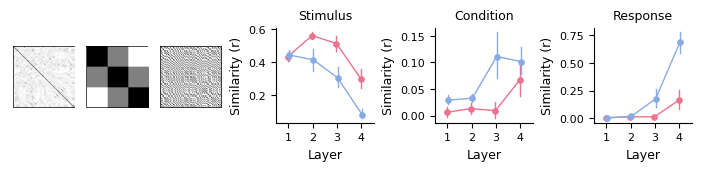

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

# parameters
pal = [(0.918, 0.451, 0.553),
       (0.537, 0.671, 0.890)]
mag = 1.2
new_pal = [(min(r * mag, 1), min(g * mag, 1), min(b * mag, 1))
           for r, g, b in pal]
# generate basic figure
# create figure
fig, axs = plt.subplot_mosaic("""
                              BBCCDDEEEFFFGGG
                              """,
                              figsize=(6.9, 1.6),
                              constrained_layout=True)
# # blank
# ax = axs["A"]
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])
# sns.despine(left=True, bottom=True, ax=ax)

for (a, i) in zip(["B", "C", "D"], [0, 1 , 2]):
    ax = axs[a]
    data = np.squeeze(task_rdms[i].get_matrices())
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(data, aspect='equal', rasterized=True, cmap="gray")

    # Define the bottom-left corner, width, and height of the rectangle
    x, y = -1, -1
    width, height = 108, 108

    # Define the rectangle corners in order (closing the loop)
    x_vals = [x, x + width, x + width, x, x]
    y_vals = [y, y, y + height, y + height, y]

    # x_vals = [x, x + width]
    # y_vals = [y, y]
    # Plot the rectangle
    ax.plot(x_vals, y_vals, c="k", linewidth=0.5)  # 'b-' for blue solid line

    sns.despine(left=True, bottom=True, ax=ax)


for j, (a, target, target_label) in enumerate(zip(["E", "F", "G"],
                                                  ["visual",
                                                   "complexity",
                                                   "motor"],
                                                  ["Stimulus",
                                                   "Condition",
                                                   "Response"])):

    ax = axs[a]
    data = task_results.loc[(task_results["task_model"] == target)
                            & (task_results.layer != "average")
                            & (task_results["ann_model"] != "mlp")]
    sns.pointplot(data=data,
                  y="values",
                  x="layer",
                  hue="ann_model",
                  palette=pal,
                  linewidth=1,
                  markersize=4,
                  dodge=True,
                  zorder=10,
                  legend=False,
                  err_kws={'linewidth': 1},
                  ax=ax)

    # sns.stripplot(data=data,
    #               y="values",
    #               x="layer",
    #               hue="ann_model",
    #               palette=new_pal,
    #               size=1.5,
    #               alpha=0.8,
    #               zorder=2,
    #               dodge=0.01,
    #               legend=False,
    #               ax=ax)


    # plot properties
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlabel("Layer", fontsize=9)
    ax.set_xticks([0, 1, 2, 3], [1, 2, 3, 4])
    ax.set_title(target_label, loc='center', fontsize=9, ha="center")
    sns.despine(ax=ax)
    ax.set_ylabel("Similarity (r)", fontsize=9)

plt.savefig("../figures/task_RSA.svg", dpi=1200)
plt.show()